# 1. Get sentences

In [ ]:
import json
import pandas as pd

# dataset = 'msvd'
dataset = 'msrvtt'

def msvd_load_captions(caption_fpath):
    df = pd.read_csv(caption_fpath)
    df = df[df['Language'] == 'English']
    df = df[pd.notnull(df['Description'])]
    captions = df['Description'].values
    return captions

if dataset == 'msvd':
    cnt = 0
    train_id_path = '../MSVD/metadata/train.list'
    train_sentence_path = '../MSVD/metadata/train.csv'
    sentence_path = '../MSVD/metadata/msvd_sentence.txt'
    w = open(sentence_path, 'a')
    sentence = msvd_load_captions(train_sentence_path)
    print(sentence.size)
    for i in range(sentence.size):
        w.writelines(sentence[i])
        w.write('\n')
        cnt += 1
    w.close()
    print(cnt)

if dataset == 'msrvtt':
    file_path = '../MSR-VTT/metadata/train.json'
    sentence_path = '../MSR-VTT/metadata/msrvtt_sentence.txt'
    list1 = []
    cnt = 0

    with open(file_path, 'r') as f:
        load_data = json.load(f)
        f.close()
    w = open(sentence_path, 'a')
    # print(load_data, type(load_data))
    for i in load_data.keys():
        list1.append(load_data[i])
    for j in range(len(list1)):
        for key in list1[j]:
            w.writelines(list1[j][key])
            w.write('\n')
            cnt += 1
            print(list1[j][key])
    w.close()
    print(cnt)

# 2. Extract triples from sentences using Standford NLP

In [ ]:
import spacy
from stanfordcorenlp import StanfordCoreNLP
import json
import tqdm

spacy_nlp = spacy.load("en_core_web_sm")

# Load Stanford CoreNLP
nlp = StanfordCoreNLP(r'./Tool/stanford-corenlp-4.2.2')

sentence_path = './data/MSRV-TT/metadata/msrvtt_sentence.txt'
entity_rel_path = './OpenKE/benchmarks/MSRV-TT/entity_extracted.txt'
log_path = './OpenKE/benchmarks/MSRV-TT/error_log.txt'

f = open(sentence_path, 'r')
w = open(entity_rel_path, 'w')
log = open(log_path, 'w')
lines = f.readlines()
cnt = 0
num_rel = 0

for line in tqdm.tqdm(lines):
    sentence = line.strip()
    try:
        # Parse bằng Stanford CoreNLP
        output = nlp.annotate(sentence, properties={
            "annotators": "tokenize,lemma,ssplit,pos,depparse,natlog,openie",
            "outputFormat": "json",
            'openie.triple.strict': 'true',
            'openie.max_entailments_per_clause': '1'
        })

        data = json.loads(output)
        # POS tagging bằng spaCy
        spacy_doc = spacy_nlp(sentence)
        spacy_tokens = [token for token in spacy_doc]

        for i in range(len(data['sentences'])):
            result = [data["sentences"][i]["openie"]]
            cnt += 1

            for g in result:
                for rel in g:
                    subj_start, subj_end = rel['subjectSpan']
                    obj_start, obj_end = rel['objectSpan']
                    rel_start, rel_end = rel['relationSpan']

                    # Check valid spans
                    if max(subj_end, obj_end, rel_end) > len(spacy_tokens):
                        log.write(f"[Warning] Span out of range at sentence {cnt}: {sentence}\n")
                        continue

                    # Lấy token trong các span
                    subj_tokens = [
                        token.lemma_ for token in spacy_tokens[subj_start:subj_end]
                        if token.tag_.startswith('NN')
                    ]
                    obj_tokens = [
                        token.lemma_ for token in spacy_tokens[obj_start:obj_end]
                        if token.tag_.startswith('NN')
                    ]
                    rel_tokens = [
                        token.lemma_ for token in spacy_tokens[rel_start:rel_end]
                        if token.tag_.startswith('VB')
                    ]

                    l_subject = ' '.join(subj_tokens)
                    l_object = ' '.join(obj_tokens)
                    l_relation = ' '.join(rel_tokens)

                    if not l_subject or not l_object or not l_relation:
                        continue

                    relationSent = f"{l_subject.strip()} &{l_object.strip()} &{l_relation.strip()}"
                    w.write(relationSent + '\n')
                    num_rel += 1

    except Exception as e:
        log.write(f"[Error] Exception at sentence {cnt}: {sentence}\n")
        log.write(f"         Error message: {str(e)}\n")

print('Result written to:', entity_rel_path)
print('Error log written to:', log_path)
print('Total number of processed sentences: ' + str(cnt))
print('Total number of relations extracted: ' + str(num_rel))

w.close()
f.close()
log.close()

# 3. Screening and de-duplication

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import words

# dataset = 'MSVD'
dataset = 'MSRV-TT'
english_vocab = set(words.words())
stopwords = set(stopwords.words('english'))
obj_vocab = set()

akg_vocab = set()

with open('./data/akg_vocab.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            akg_vocab.add(line)

input_path = f'./OpenKE/benchmarks/{dataset}/entity_extracted.txt'

def load_triples(filepath):
    triples = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = [x.strip() for x in line.strip().split('&')]
            if len(parts) == 3:
                head, tail, rel = parts
                triples.append((head, rel, tail))  # (h, r, t)
    return triples

def normalize_text(text):
    quantifiers = {
        "some", "many", "several", "few", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
        "all", "both", "each", "every", "no", "none", "any", "most", "more", "less"
    }
    quantifiers.update(str(i) for i in range(1, 51))
    text = text.lower()
    text = re.sub(rf"[{string.punctuation}]", "", text)
    tokens = text.strip().split()
    tokens = [w for w in tokens if w not in stopwords.union(quantifiers)]
    return ' '.join(tokens)

def is_valid_entity(entity):
    tokens = entity.split()
    for token in tokens:
        if len(token) == 1 or not token.isalpha() or token not in english_vocab:
            return False
        if token in akg_vocab:
            continue
    return True

def filter_triples(triples):
    remove_relations = {"be", "have", "do", "get", "can", "is", "are"}
    filtered = []
    for h, r, t in triples:
        if r in remove_relations:
            continue

        if len(h.split()) < 1 or len(t.split()) < 1:
            continue

        if len(h.split()) > 1 or len(t.split()) > 1 or len(r.split()) > 1:
            continue

        if not is_valid_entity(h) or not is_valid_entity(t) or not is_valid_entity(r):
            continue

        filtered.append((h, r, t))
    return filtered

def normalize_triples(triples):
    norm_triples = []
    for h, r, t in triples:
        norm_h = normalize_text(h)
        norm_t = normalize_text(t)
        norm_r = normalize_text(r)
        if norm_h and norm_t and norm_r:
            norm_triples.append((norm_h, norm_r, norm_t))
    return norm_triples

def deduplicate_triples(triples):
    return list(set(triples))

triples = load_triples(input_path)
triples = normalize_triples(triples)
triples = filter_triples(triples)
triples = deduplicate_triples(triples)
print('number of triples:', len(triples))

In [ ]:
# Save the triples to file
entity_path = f'./OpenKE/benchmarks/{dataset}/entity_total.txt'
cnt = 0

for h, r, t in triples:
    w = open(entity_path, 'a')
    w.write(f"{h} &{t} &{r}\n")
    w.close()

# 4. Visualize

In [ ]:
entity_path = f'./OpenKE/benchmarks/{dataset}/entity_total.txt'

def load_triples(filepath):
    triples = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = [x.strip() for x in line.strip().split('&')]
            if len(parts) == 3:
                head, tail, rel = parts
                triples.append((head, rel, tail))  # (h, r, t)
    return triples
triples = load_triples(entity_path)

🔠 Top head words: [('man', 2056), ('woman', 1091), ('person', 705), ('someone', 472), ('girl', 409), ('cat', 392), ('lady', 350), ('boy', 330), ('dog', 321), ('people', 151)]
🔗 Top relation words: [('play', 571), ('cut', 379), ('slice', 258), ('make', 218), ('ride', 211), ('eat', 195), ('run', 192), ('walk', 189), ('put', 184), ('dance', 143)]
🔚 Top tail words: [('water', 158), ('something', 154), ('pan', 128), ('egg', 105), ('food', 102), ('car', 100), ('bowl', 97), ('man', 80), ('floor', 79), ('meat', 76)]


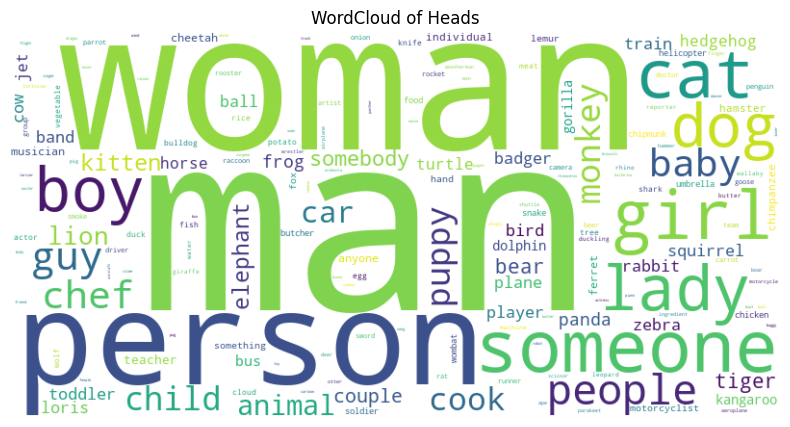

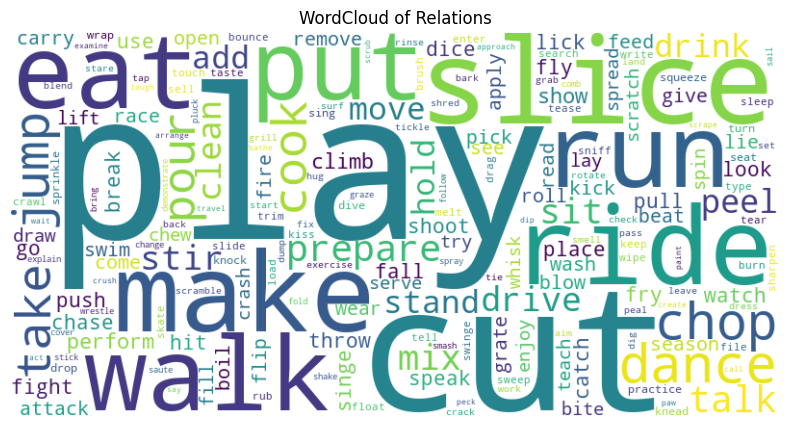

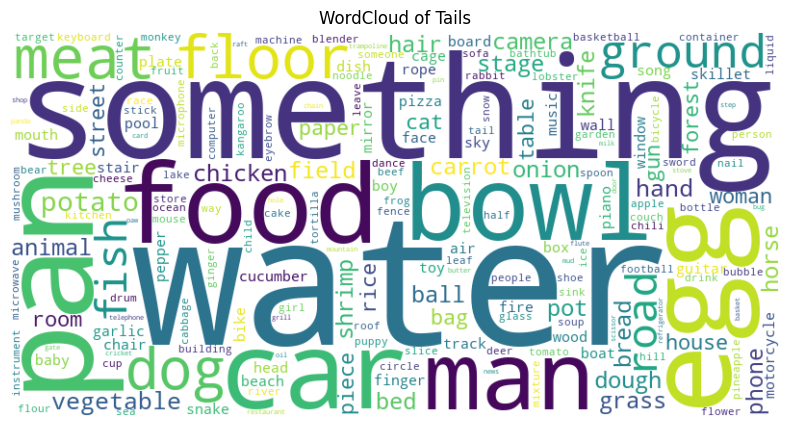

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Đếm từ cho từng phần
head_words = ' '.join([h for h, r, t in triples]).split()
rel_words = ' '.join([r for h, r, t in triples]).split()
tail_words = ' '.join([t for h, r, t in triples]).split()

# Đếm tần suất
head_counts = Counter(head_words)
rel_counts = Counter(rel_words)
tail_counts = Counter(tail_words)

# In top 10 từ phổ biến nhất
print("🔠 Top head words:", head_counts.most_common(10))
print("🔗 Top relation words:", rel_counts.most_common(10))
print("🔚 Top tail words:", tail_counts.most_common(10))

# Tạo WordCloud từ Counter
def show_wordcloud(counter, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Hiển thị từng phần
show_wordcloud(head_counts, "WordCloud of Heads")
show_wordcloud(rel_counts, "WordCloud of Relations")
show_wordcloud(tail_counts, "WordCloud of Tails")

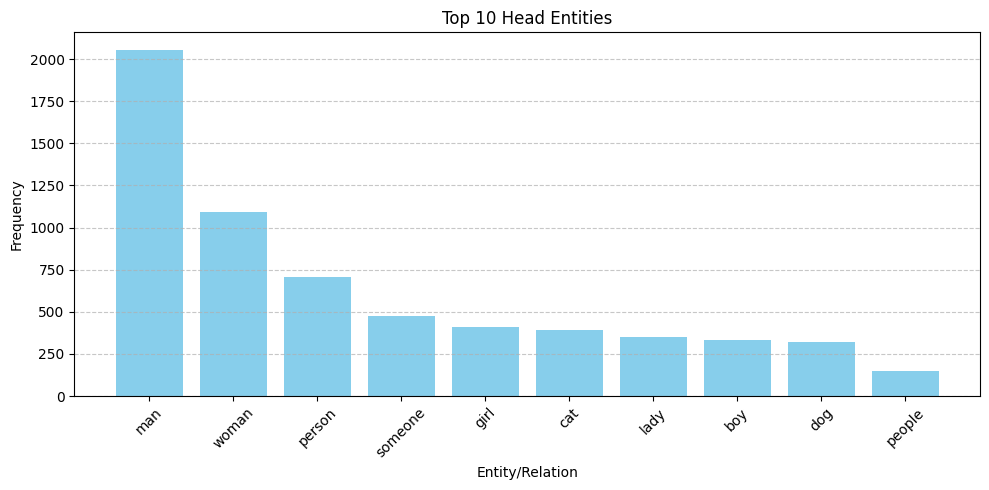

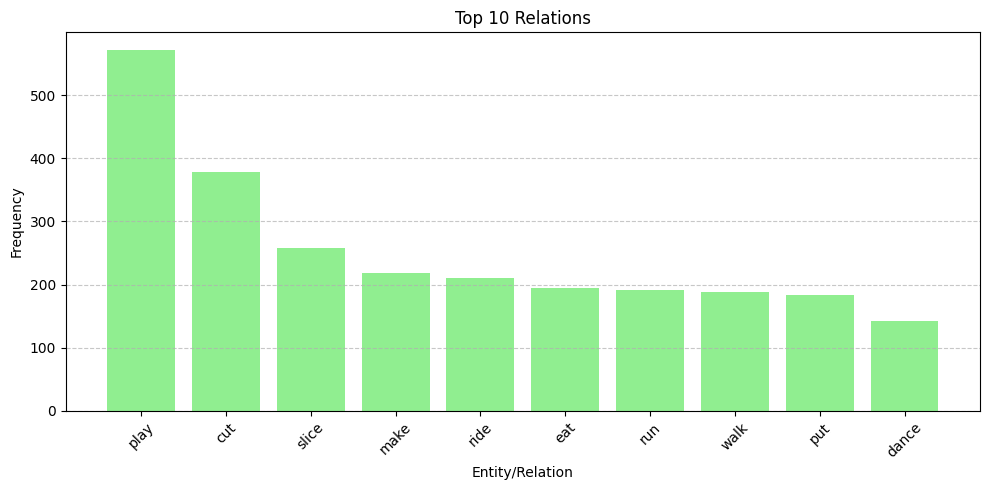

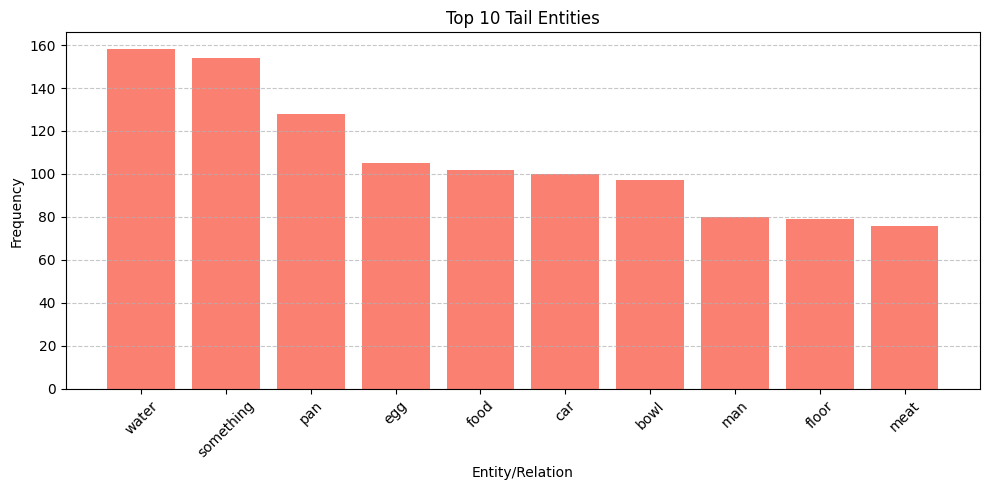

In [10]:
import matplotlib.pyplot as plt

def plot_bar(data, title, color):
    labels, counts = zip(*data)
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color=color)
    plt.title(title)
    plt.xlabel('Entity/Relation')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_bar(head_counts.most_common(10), "Top 10 Head Entities", "skyblue")
plot_bar(rel_counts.most_common(10), "Top 10 Relations", "lightgreen")
plot_bar(tail_counts.most_common(10), "Top 10 Tail Entities", "salmon")

In [ ]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import random

k = 20

sampled_triples = random.sample(triples, k)

df = pd.DataFrame(sampled_triples, columns=['head', 'relation', 'tail'])

# Tạo graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], label=row['relation'])

# Layout
pos = nx.fruchterman_reingold_layout(G, k=0.5)

# Edge trace
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=0.5, color='gray'),
        hoverinfo='none'
    )
    edge_traces.append(edge_trace)

# Node trace
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    marker=dict(size=20, color='lightblue'),
    text=[node for node in G.nodes()],
    textposition='top center',
    hoverinfo='text',
    textfont=dict(size=10)
)

# Edge label trace (relation names)
edge_label_trace = go.Scatter(
    x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in G.edges()],
    y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in G.edges()],
    mode='text',
    text=[G[edge[0]][edge[1]]['label'] for edge in G.edges()],
    textposition='middle center',
    hoverinfo='none',
    textfont=dict(size=9, color='black')
)

# Layout
layout = go.Layout(
    title=dict(
        font=dict(size=16),
        x=0.5  # căn giữa tiêu đề
    ),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(visible=False),
    yaxis=dict(visible=False)
)

# Figure
fig = go.Figure(data=edge_traces + [node_trace, edge_label_trace], layout=layout)
fig.show()

# 5. Build knowledgeid for TransE

In [ ]:
import random
import os

def generate_mappings(triples):
    entity2id, relation2id = {}, {}
    eid, rid = 0, 0
    for h, r, t in triples:
        for ent in [h, t]:
            if ent not in entity2id:
                entity2id[ent] = eid
                eid += 1
        if r not in relation2id:
            relation2id[r] = rid
            rid += 1
    return entity2id, relation2id

def split_data(triples, val_ratio=0.1, test_ratio=0.1):
    random.seed(42) 
    random.shuffle(triples)
    n = len(triples)
    test_size = int(n * test_ratio)
    val_size = int(n * val_ratio)
    test_triples = triples[:test_size]
    val_triples = triples[test_size:test_size+val_size]
    train_triples = triples[test_size+val_size:]
    return train_triples, val_triples, test_triples

def write_output(train_triples, val_triples, test_triples, entity2id, relation2id, path):
    files = [
        'train2id.txt',
        'valid2id.txt',
        'test2id.txt',
        'entity2id.txt',
        'relation2id.txt'
    ]
    
    # Xóa file cũ nếu tồn tại
    for file in files:
        file_path = os.path.join(path, file)
        if os.path.exists(file_path):
            os.remove(file_path)

    # Train
    with open(os.path.join(path, 'train2id.txt'), 'w') as f:
        f.write(f"{len(train_triples)}\n")
        for h, r, t in train_triples:
            f.write(f"{entity2id[h]}\t{entity2id[t]}\t{relation2id[r]}\n")

    # Validation
    with open(os.path.join(path, 'valid2id.txt'), 'w') as f:
        f.write(f"{len(val_triples)}\n")
        for h, r, t in val_triples:
            f.write(f"{entity2id[h]}\t{entity2id[t]}\t{relation2id[r]}\n")

    # Test
    with open(os.path.join(path, 'test2id.txt'), 'w') as f:
        f.write(f"{len(test_triples)}\n")
        for h, r, t in test_triples:
            f.write(f"{entity2id[h]}\t{entity2id[t]}\t{relation2id[r]}\n")

    # Entities
    with open(os.path.join(path, 'entity2id.txt'), 'w') as f:
        f.write(f"{len(entity2id)}\n")
        for e, i in entity2id.items():
            f.write(f"{e}\t{i}\n")

    # Relations
    with open(os.path.join(path, 'relation2id.txt'), 'w') as f:
        f.write(f"{len(relation2id)}\n")
        for r, i in relation2id.items():
            f.write(f"{r}\t{i}\n")

entity2id, relation2id = generate_mappings(triples)
train_triples, val_triples, test_triples = split_data(triples)

print(f"Number of entities: {len(entity2id)}")
print(f"Number of relations: {len(relation2id)}")
print(f"Train triples: {len(train_triples)}")
print(f"Validation triples: {len(val_triples)}")
print(f"Test triples: {len(test_triples)}")

write_output(train_triples, val_triples, test_triples, entity2id, relation2id, path=f"./OpenKE/benchmarks/{dataset}")